# Homework - Vertical FL and Generative Modeling
Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, generative modeling creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 



# Instructions

Submit your assignment as a Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

## Question 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **5** random feature permutations and plot the training loss. Report whether shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 5 feature permutations with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) the permutations have on the loss and explain the observed pattern.

'Random' means random in 13 labels like this: \
Client feature names: ['age', 'sex', 'cp', 'trestbps', 'chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

In [2]:
class BottomModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(BottomModel, self).__init__()
        self.local_out_dim = out_feat
        self.fc1 = nn.Linear(in_feat, out_feat)
        self.fc2 = nn.Linear(out_feat, out_feat)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.dropout(self.act(self.fc2(x)))
    
    
class TopModel(nn.Module):
    def __init__(self, local_models, n_outs):
        super(TopModel, self).__init__()
        self.in_size = sum([local_models[i].local_out_dim for i in range(len(local_models))])
        self.fc1 = nn.Linear(self.in_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        concat_outs = torch.cat(x, dim=1)  # concatenate local model outputs before forward pass
        x = self.act(self.fc1(concat_outs))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.dropout(x)
    
    
class VFLNetwork(nn.Module):
    def __init__(self, local_models, n_outs):
        super(VFLNetwork, self).__init__()
        self.num_cli = None  # the number of clients
        self.cli_features = None  # the set of features corresponding to a client
        self.bottom_models = local_models
        self.top_model = TopModel(self.bottom_models, n_outs)
        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = nn.CrossEntropyLoss()

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        self.num_cli = n_cli  
        self.cli_features = cli_features  
        x = x.astype('float32')
        y = y.astype('float32')
        # devide dataset by cli_features, they are not equal due to one-hot label
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)
        num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        train_loss = []
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz):] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):]
                else:
                    x_minibatch = [x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]
                outs = self.forward(x_minibatch)
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, y_minibatch)
                total_loss += loss
                loss.backward()
                self.optimizer.step()
            train_loss.append(total_loss.detach())
            if epoch%100 == 0:
                print(f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {total_loss.detach().numpy()/num_batches:.3f}")
        return train_loss

    # Automatic Parallel for this loop in GPU
    def forward(self, x):
        local_outs = [self.bottom_models[i](x[i]) for i in range(len(self.bottom_models))]
        return self.top_model(local_outs)

    def test(self, x, y):
        x = x.astype('float32')
        y = y.astype('float32')
        x_test = [torch.tensor(x[feats].values) for feats in self.cli_features]
        y_test = torch.tensor(y.values)
        with torch.no_grad():
            outs = self.forward(x_test)
            preds = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_test, dim=1)
            accuracy = torch.sum((preds == actual)) / len(actual)
            loss = self.criterion(outs, y_test)
            return accuracy, loss

In [3]:
def preprocess_data(seed = None, num_clients = 4, random_shuffle = False, Equally = True, True_Equally = False, Feature4Client = None, file_path = "heart-dataset/heart.csv"):    
    df = pd.read_csv(file_path)
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  #convert categorical features to one-hot embeddings
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    # decide how many features each client can have here
    if Equally:
        features_per_client = (num_clients - 1) * [(len(df.columns) - 1) // num_clients]  # "equally" partition the features
        features_per_client.append(len(df.columns) - 1 - sum(features_per_client))
    elif True_Equally:
        quotient = (len(df.columns)-1) // num_clients
        remainder = (len(df.columns)-1) % num_clients
        features_per_client = [quotient + (1 if i < remainder else 0) for i in range(num_clients)]
    else:
        features_per_client = (num_clients - 1) * [Feature4Client]
        features_per_client.append(len(df.columns) - 1 - sum(features_per_client))  
    features_per_client = np.array(features_per_client)
    
    all_feature_names = list(df.columns)
    all_feature_names.pop()
    client_feature_names = []
    csum_features_per_client = np.cumsum(features_per_client)
    encoded_df_feature_names = list(X.columns)
    start_index = 0
    remaining_features = all_feature_names.copy()

    for num_feats in features_per_client:
        # decide select which feature here, use seed, do shuffling
        if random_shuffle:
            random.seed(seed)
            feat_names = random.sample(remaining_features, num_feats)
            remaining_features = [feat for feat in remaining_features if feat not in feat_names]
        else:
            feat_names = all_feature_names[start_index:start_index + num_feats]
            start_index = start_index + num_feats
        client_feature_names.append(feat_names)

    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical_cols:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    # there is _ in label feature after one-hot embeddings
                    if '_' in name and column_name in name:
                        updated_names.append(name)
        client_feature_names[i] = updated_names
        
    return X, Y, client_feature_names, features_per_client

In [4]:
def model_initial(client_feature_names):
    # model architecture hyperparameters
    outs_per_client = 2 # 2 * in_channel
    bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
    final_out_dims = 2 # just true or false for classification
    Network = VFLNetwork(bottom_models, final_out_dims)
    return Network

In [5]:
def train_test(X, Y, Network, client_feature_names, num_clients = 4, EPOCHS = 300, BATCH_SIZE = 64, TRAIN_TEST_THRESH = 0.8):
    X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
    Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]
    train_loss = Network.train_with_settings(EPOCHS, BATCH_SIZE, num_clients,
                                client_feature_names, X_train, Y_train)
    accuracy, loss = Network.test(X_test, Y_test)
    print(f"Test accuracy: {accuracy * 100:.2f}%")
    return train_loss

In [6]:
def loss_visualize_Q1(loss, random_shuffling, seed):
    for i, l in enumerate(loss):
        plt.plot(l, label=f'Experiment {i+1} - Shuffle: {random_shuffling[i]} - Seed: {seed[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Convergence rates per Experiment')
    plt.legend()
    plt.show()

In [7]:
def Question_1():
    # Here I tried five random seed, and two original order at begin and end
    seed = ['none', 7, 42, 3407, 20011005, 20001114, 'none']
    random_shuffling = [False, True, True, True, True, True, False]
    loss = []
    for index in range(len(random_shuffling)):
        print(f"----------------Random shuffle: {random_shuffling[index]}----------------")
        X, Y, client_feature_names, _ = preprocess_data(seed = seed[index], random_shuffle = random_shuffling[index])
        print(f"Client feature names: {client_feature_names}")
        Network = model_initial(client_feature_names)
        train_loss = train_test(X, Y, Network, client_feature_names)
        loss.append(train_loss)
    loss_visualize_Q1(loss, random_shuffling, seed)

----------------Random shuffle: False----------------
Client feature names: [['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3'], ['trestbps', 'chol', 'fbs_0', 'fbs_1'], ['restecg_0', 'restecg_1', 'restecg_2', 'thalach', 'exang_0', 'exang_1'], ['oldpeak', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
Epoch: 0 Train accuracy: 53.96% Loss: 0.693
Epoch: 100 Train accuracy: 85.38% Loss: 0.366
Epoch: 200 Train accuracy: 87.45% Loss: 0.305
Test accuracy: 83.82%
----------------Random shuffle: True----------------
Client feature names: [['fbs_0', 'fbs_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2'], ['exang_0', 'exang_1', 'trestbps', 'oldpeak'], ['chol', 'sex_0', 'sex_1', 'thalach'], ['ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'age', 'slope_0', 'slope_1', 'slope_2', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
Epoch: 0 Train accuracy: 61.27% Loss: 0.678
Epoch: 100 Train accuracy: 88.06% Loss: 0.330
E

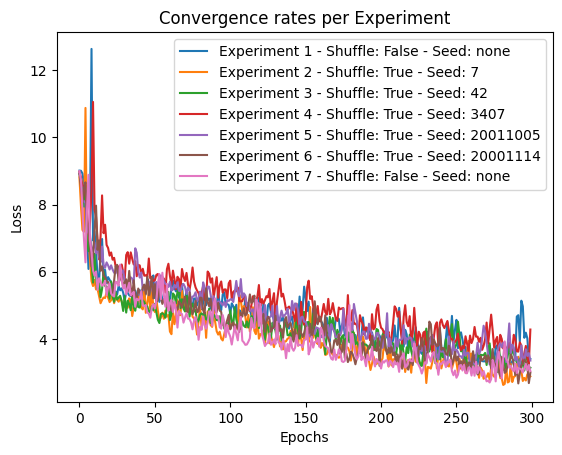

In [8]:
Question_1()

`Results` I did five shuffles, and two without shuffles. the results are shown in the picture. You can clearly see that their convergence rates are not so different.

`Analysis` age,sex,cp... these features are not logically related, so whether they are shuffled or not doesn't affect anything. It doesn't matter how you reverse their order.

## Question 2: Scaling clients in VFL (4 points)

With the same template code, experiment with how increasing the number of clients affects model performance. Plot the training loss with 2, 4, and 8 clients. Try a best-effort equal partitioning for the features, with the remaining extra features assigned to the last client. For example, with 14 features and three clients, assign four features to clients 1 and 2 and six to client 3. Report your reasoning for the observed output.

Scoring:
- _(1 point)_ Create the best-effort equal feature splits for the requested client counts (use the default ordering in the dataset) and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

- About 'best-effort equal feature splits', I implemented two more segmentation methods. One is to try to get all clients to split the same or approximate number of features; the other is implemented as in the example you gave: specify how many features each client should get, and split the remaining features to the last client. 

- I tested the original equality split, my proposed true equality split, and the split you mentioned with num_clients = 3 and Feature4Client = 4 in the code below, for a total of seven scenarios. 

In [8]:
def loss_visualize_Q2(loss, num_clients, features_per_client_list):
    for i, l in enumerate(loss):
        plt.plot(l, label=f'Clients: {num_clients[i]} - Features per client: {features_per_client_list[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Convergence rates per Experiment')
    plt.legend()
    plt.show()

In [9]:
def Question_2(num_clients, loss, features_per_client_list, Equally = True, True_Equally = False, Feature4Client = None):

    for index in range(len(num_clients)):
        print(f"----------------Clients: {num_clients[index]}----------------")
        X, Y, client_feature_names, features_per_client = preprocess_data(num_clients = num_clients[index], Equally = Equally, True_Equally = True_Equally, Feature4Client = Feature4Client)
        print('features_per_client: ', features_per_client)
        features_per_client_list.append(features_per_client)
        Network = model_initial(client_feature_names)
        train_loss = train_test(X, Y, Network, client_feature_names, num_clients = num_clients[index])
        loss.append(train_loss)
    
    return loss, features_per_client_list

----------------Clients: 1----------------
features_per_client:  [13]
Epoch: 0 Train accuracy: 56.03% Loss: 0.685
Epoch: 100 Train accuracy: 88.92% Loss: 0.283
Epoch: 200 Train accuracy: 92.20% Loss: 0.208
Test accuracy: 86.27%
----------------Clients: 2----------------
features_per_client:  [6 7]
Epoch: 0 Train accuracy: 51.40% Loss: 0.689
Epoch: 100 Train accuracy: 89.65% Loss: 0.303
Epoch: 200 Train accuracy: 92.57% Loss: 0.227
Test accuracy: 85.78%
----------------Clients: 4----------------
features_per_client:  [3 3 3 4]
Epoch: 0 Train accuracy: 56.76% Loss: 0.684
Epoch: 100 Train accuracy: 85.99% Loss: 0.328
Epoch: 200 Train accuracy: 90.62% Loss: 0.254
Test accuracy: 87.25%
----------------Clients: 8----------------
features_per_client:  [1 1 1 1 1 1 1 6]
Epoch: 0 Train accuracy: 51.77% Loss: 0.689
Epoch: 100 Train accuracy: 86.85% Loss: 0.355
Epoch: 200 Train accuracy: 88.55% Loss: 0.300
Test accuracy: 90.20%
----------------Clients: 2----------------
features_per_client:  [7 6

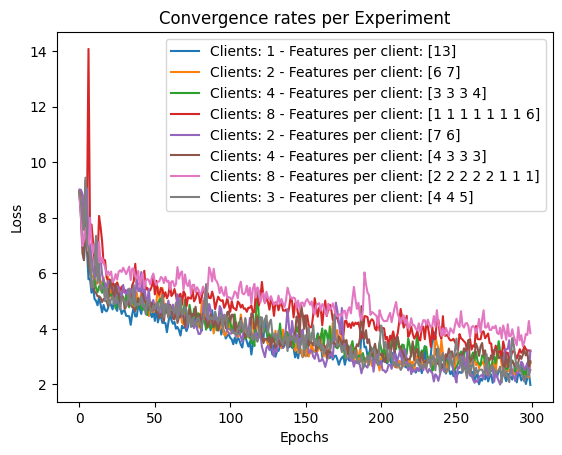

In [14]:
loss = []
features_per_client_list = []
num_clients = [1, 2, 4, 8, 2, 4, 8, 3]
loss, features_per_client_list = Question_2(num_clients[0:4], loss, features_per_client_list, Equally = True)
# True_Equally indicates that the number of features assigned to each client is as equal or close as possible.
loss, features_per_client_list = Question_2(num_clients[4:7], loss, features_per_client_list, Equally = False, True_Equally = True)
# Exhausting Feature4Client is a bit complicated so I only tested the kind of case you mentioned.
loss, features_per_client_list = Question_2([num_clients[-1]], loss, features_per_client_list, Equally = False, True_Equally = False, Feature4Client = 4)
loss_visualize_Q2(loss, num_clients, features_per_client_list)

Obviously, the more the clients are divided, the slower the convergence and the worse the performance on the test machine. 

I have by the way tested the case with client=1 which means no federated learning, the blue one, it perform best among others. Second is the purple-clients:2, etc.

Here's an interesting phenomenon: when Clients=8, [2 2 2 2 2 1 1 1] performs quite a bit worse than [1 1 1 1 1 1 1 6]. 

## Question 3: Bridging VFL and generative modeling (8 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. In this regard, combine VFL with variational autoencoders (VAEs) by following the architecture shown in the figure below. Each client uses a local network, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another MLP. Code the necessary components using the templates from [lab-vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb) and [generative_modeling.py](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/generative_modeling.py). Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features similarly to the discriminative model VFL lab.
- _(2 points)_ Define the input & output MLP networks to be used by clients.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, printing the loss at every epoch.

![vflvae.png](vflvae.png)

The order of my code is as follows:

- Define class VAE_BottomModel

- Define class VAE_TopModel

- Define class VAE_VFLNetwork

- Define data_process()

- Define model_initial()

- Define train_test()

- Define loss_visualize()

- Experiment

In [161]:
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### _(2 points)_ Define the input & output MLP networks to be used by clients.

- First we need to know how to divide the architecture of VAE. VAE is divided into three parts: `encoder`, `latent layer`, `decoder`. and the latent layer includes `vector sampling` and `reparameterize`.

- So each client has an `encoder` and a `decoder`, and the dimensions of their inputs and outputs depend on the dimensions of the data provided by the user.

- And Server has `latent layer` which includes vector sampling and reparameterize.

- It is important to note here that I have divided the middle layer `self.fc1 = nn.Linear(H2, latent_dim)` and `self.fc4 = nn.Linear(latent_dim, H2)` to `encoder` and `decoder` respectively. This allows the features uploaded by each client to be spliced without being too long.

- For convenience and aesthetics, I wrote only one `forward()`. I used `forward_step = 'encode' or 'decode'` as a condition to distinguish between the two forward propagation processes.

The bottom model is shown below:


In [162]:
# VAE_BottomModel has the encoder and decoder, using by clients
class VAE_BottomModel(nn.Module):
    def __init__(self, D_in, H=50, H2=12, latent_dim=3):
        super(VAE_BottomModel, self).__init__()

        # for Encoder
        self.optimizer = None
        self.criterion = None
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # get latent vectors, so it won't be too large after concatenate
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)

        # get mu and sigma, vector sampling and reparameterize are done on server

        # latent_dim -> H2 in local
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # for Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        return fc1
    
    def decode(self, z):
        fc4 = self.relu(self.fc_bn4(self.fc4(z)))
        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    # Use forward_step to switch the process, make it nice to see
    def forward(self, x, forward_step = 'encode'):
        if forward_step=='encode':
            x = self.encode(x)
            return x
        else:
            return self.decode(x)

### _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.

- The top model is shown below. 

- You can see I put `self.fc3 = nn.Linear(latent_con_dim, latent_con_dim)` here after doing reparameterize, since I think `self.fc3` is also a part of latent layer, and it is easy to split them into different channels as the input channel look like.

- In `Forward()`, each feature from different clients first need to be concatenate at dimension 1. After process, them need to be split into bunch of feature again, depend on their original size.

- I calculate `mu` and `sigma` after concatenate those features, since this is easy to do. And I wish the VAE to have a more "global" probability distribution. 

- On the other hand, I think the `mu` and `sigma` computed on the individual client's features are only local and not global, and concatenate these `mu` and `sigma` together may not be a wise decision(just a guess).

In [163]:
# VAE_TopModel has the Vector sampling and reparameterize, using by server
class VAE_TopModel(nn.Module):
    def __init__(self, latent_con_dim):
        super(VAE_TopModel, self).__init__()
        self.latent_dim = latent_con_dim
        # get latent vectors mu and sigma
        self.fc21 = nn.Linear(latent_con_dim, latent_con_dim)
        self.fc22 = nn.Linear(latent_con_dim, latent_con_dim)
        # Sampling vector
        self.fc3 = nn.Linear(latent_con_dim, latent_con_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_con_dim)

        self.relu = nn.ReLU()
    
    def encode(self, x):
        r1 = self.fc21(x)
        r2 = self.fc22(x)
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def sample(self, nr_samples, mu, logvar):
        sigma = torch.exp(logvar / 2)
        no_samples = nr_samples
        q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
        z = q.rsample(sample_shape=torch.Size([no_samples]))
        with torch.no_grad():
            pred = self.decode(z).cpu().numpy()
        pred[:, -1] = np.clip(pred[:, -1], 0, 1)
        pred[:, -1] = np.round(pred[:, -1])
        return pred

    # only need to get mu, sigma, do reparameterize and vector sampling
    # I think vector sampling is more like a middle-part, not a decoder-part, so I put it here, but latent_dim to H2 is in bottom model
    def forward(self, x, output_sizes):
        concat_outs = torch.cat(x, dim=1)  # notice: you can also concat mu and sigma here, depend on you(?)
        mu, logvar = self.encode(concat_outs)
        z = self.reparameterize(mu, logvar)
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        # split latent features
        split_outs = torch.split(fc3, output_sizes, dim=1)
        return split_outs, mu, logvar

### _(2 points)_ Define the VFL network that fits together the client networks and that of the server.

- The VFL network is shown below. 

- The difficulties in this section are: how the process of forward propagation is defined, how to divide the training dataset, and how to calculate the loss.

- See the comments in the code for details.

In [164]:
class VAE_VFLNetwork(nn.Module):
    def __init__(self, local_models, latent_con_dim, output_sizes):
        super(VAE_VFLNetwork, self).__init__()
        self.latent_con_dim = latent_con_dim
        self.output_sizes = output_sizes
        self.num_cli = None
        self.cli_features = None
        self.bottom_models = local_models
        self.top_model = VAE_TopModel(latent_con_dim)
        self.optimizer = optim.AdamW(self.parameters())

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, real_data, optimizer, loss_fn):
        self.num_cli = n_cli  
        self.cli_features = cli_features
        self.optimizer = optimizer
        self.criterion = loss_fn
        # print('len(real_data[0]):', len(real_data[0]))
        num_batches = len(real_data[0]) // batch_sz if len(real_data[0]) % batch_sz == 0 else len(real_data[0]) // batch_sz + 1
        train_loss = []
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    minibatch_data = [r_data[int(minibatch * batch_sz):] for r_data in real_data]
                else:
                    minibatch_data = [r_data[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for r_data in real_data]

                outs, mu, logvar = self.forward(minibatch_data)
                # outs and minibatch are list, so we need to concat them
                outs = torch.cat(outs, dim=1)
                minibatch = torch.cat(minibatch_data, dim=1)
                loss = self.criterion(outs, minibatch, mu, logvar)
                total_loss += loss
                loss.backward()
                self.optimizer.step()
            train_loss.append(total_loss.detach())
            if epoch%2000 == 0:
                print(
                    f"Epoch: {epoch} Loss: {total_loss.detach().numpy() / num_batches:.3f}")
        return train_loss

    # bottom_model.encoder -> top_model.latent -> bottom_model.decoder
    def forward(self, x):
        
        # bottom_model.encoder
        forward_step = 'encode'
        local_outs = [self.bottom_models[i](x[i], forward_step) for i in range(len(self.bottom_models))]

        # top_model.latent
        latent_outs, mu, logvar = self.top_model(local_outs, self.output_sizes)
            
        # bottom_model.decoder
        forward_step = 'decode'
        result = [self.bottom_models[i](latent_outs[i], forward_step) for i in range(len(self.bottom_models))]

        return result, mu, logvar
    # local_outs:  [3, 64, [8, 7, 16]] # mu:  torch.Size([64, 31]) # logvar:  torch.Size([64, 31])

    def test(self, real_data_test, loss_fn):
        self.criterion = loss_fn
        with torch.no_grad():
            outs, mu, logvar = self.forward(real_data_test)
            outs = torch.cat(outs, dim=1)
            real_data_test = torch.cat(real_data_test, dim=1)
            # print('outs: ', outs.size(), 'real_data_test: ', real_data_test.size())
            loss = self.criterion(outs, real_data_test, mu, logvar)
            return loss.detach().numpy()

### _(1 point)_ Preprocess the dataset and partition the features similarly to the discriminative model VFL lab.

The flow of data processing is as follows:
- `data_process()` encodes the data into one-hot, decides how to partition the features, and returns the column names: `client_feature_names`. Note that the training set in generative_modeling.py contains `target`, so we can no longer use `len(df.columns) - 1` and `all_feature_names.pop()` when dividing the features. 

- `model_initial()` using `client_feature_names` to decide the input and output channel of each clients with their encoder and decoder, also the server's VAE, intialize them;

- `train_test()` defines how to divide the training and test sets, the `StandardScaler()` processing of the dataset, concatenating `X` and `Y` into `real_data`, and dividing the `real_data` into arrays for different clients based on `client_feature_names`. Note that in lab-vfl.ipynb, this step is done in `Network.train_with_settings()`. I felt that because the introduction of `real_data` resulted in the need to pass additional parameters to `train_with_settings()`, it was very cumbersome, so I put it here.

- `Network.train_with_settings()`: Since I've already processed the real_data in the previous step, `train_with_settings()` just needs to divide the minibatch based on `len(real_data[0])`.

The data_process() is as follows:

In [165]:
from generative_modeling import train_test_split, StandardScaler, Autoencoder, customLoss, EvaluatorModel, accuracy_score

def data_process(seed = None, num_clients = 3, random_shuffle = False, Equally = True, True_Equally = False, Feature4Client = None, file_path = "heart-dataset/heart.csv"):
    df = pd.read_csv(file_path)
    categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    encoded_df = pd.get_dummies(df, columns=categorical)
    X = encoded_df.drop("target", axis=1)
    y = encoded_df['target']
    real_data = encoded_df

    # decide how many features each client can have here
    if Equally:
        features_per_client = (num_clients - 1) * [(len(df.columns)) // num_clients]  # "equally" partition the features
        features_per_client.append(len(df.columns) - sum(features_per_client))
    elif True_Equally:
        quotient = (len(df.columns)-1) // num_clients
        remainder = (len(df.columns)-1) % num_clients
        features_per_client = [quotient + (1 if i < remainder else 0) for i in range(num_clients)]
    else:
        features_per_client = (num_clients - 1) * [Feature4Client]
        features_per_client.append(len(df.columns) - 1 - sum(features_per_client))  
    features_per_client = np.array(features_per_client)
    print('features_per_client: ', features_per_client)

    all_feature_names = list(df.columns)
    # print('all_feature_names: ', all_feature_names)
    # all_feature_names.pop()
    client_feature_names = []
    # here not X but all column
    encoded_df_feature_names = list(real_data.columns)
    # print('encoded_df_feature_names: ', encoded_df_feature_names)
    start_index = 0
    remaining_features = all_feature_names.copy()

    for num_feats in features_per_client:
        if random_shuffle:
            random.seed(seed)
            feat_names = random.sample(remaining_features, num_feats)
            remaining_features = [feat for feat in remaining_features if feat not in feat_names]
        else:
            feat_names = all_feature_names[start_index:start_index + num_feats]
            start_index = start_index + num_feats
        client_feature_names.append(feat_names)

    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    # there is _ in label feature after one-hot embeddings
                    if '_' in name and column_name in name:
                        updated_names.append(name)
        client_feature_names[i] = updated_names
    print('client_feature_names: ', client_feature_names)
        
    return X, y, client_feature_names, features_per_client

The model_initial() is as follows:

In [166]:
def model_initial(client_feature_names):
    scale = 1
    bottom_models = [VAE_BottomModel(D_in = len(in_feats), latent_dim = scale * len(in_feats)) for in_feats in client_feature_names]
    output_sizes = []
    for in_feats in client_feature_names:
        output_sizes.append(len(in_feats))
    print('output_sizes:', output_sizes)
    Network = VAE_VFLNetwork(bottom_models, latent_con_dim = sum(output_sizes), output_sizes = output_sizes)
    return Network

The train_test() is as follows:

In [167]:
def train_test(X, Y, Network, client_feature_names, num_clients = 3, EPOCHS = 300, BATCH_SIZE = 64, TRAIN_TEST_THRESH = 0.8):
    X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
    Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]

    sc = StandardScaler()
    X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

    real_data_train = pd.concat([X_train_scaled.astype('float32'), Y_train.astype('float32')], axis=1)
    real_data_test = pd.concat([X_test_scaled.astype('float32'), Y_test.astype('float32')], axis=1)

    real_data_train = [torch.tensor(real_data_train[feats].values) for feats in client_feature_names]
    real_data_test = [torch.tensor(real_data_test[feats].values) for feats in client_feature_names]

    print('data down!')

    optimizer = optim.Adam(Network.parameters(), lr=1e-4)
    loss_mse = customLoss()
    
    train_loss = Network.train_with_settings(EPOCHS, BATCH_SIZE, num_clients,
                                client_feature_names, real_data_train, optimizer, loss_fn = loss_mse)
    print('train down!')

    loss = Network.test(real_data_test, loss_fn = loss_mse)
    print(f"Test loss: {loss}")
    return train_loss

### _(1 point)_ Create and run the training loop of the complete model, printing the loss at every epoch.

- I also tested the convergence speed corresponding to different num_clients and made a visualization along the way.

In [168]:
def loss_visualize_VAE(loss, num_clients, features_per_client_list):
    for i, l in enumerate(loss):
        plt.plot(l, label=f'Clients: {num_clients[i]} - Features per client: {features_per_client_list[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Convergence rates per Experiment')
    plt.legend()
    plt.show()

----------------Clients: 1----------------
features_per_client:  [14]
client_feature_names:  [['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'trestbps', 'chol', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2', 'thalach', 'exang_0', 'exang_1', 'oldpeak', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'target']]
output_sizes: [31]
data down!
Epoch: 0 Loss: 27224.064


Epoch: 2000 Loss: 22755.082
Epoch: 4000 Loss: 22090.520
Epoch: 6000 Loss: 22024.342
Epoch: 8000 Loss: 21663.971
train down!
Test loss: 10769.8154296875
----------------Clients: 2----------------
features_per_client:  [7 7]
client_feature_names:  [['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'trestbps', 'chol', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2'], ['thalach', 'exang_0', 'exang_1', 'oldpeak', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'target']]
output_sizes: [14, 17]
data down!
Epoch: 0 Loss: 27546.930
Epoch: 2000 Loss: 20581.855
Epoch: 4000 Loss: 19656.637
Epoch: 6000 Loss: 19124.076
Epoch: 8000 Loss: 18881.211
train down!
Test loss: 9691.5341796875
----------------Clients: 3----------------
features_per_client:  [4 4 6]
client_feature_names:  [['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'trestbps'], ['chol', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2', 'tha

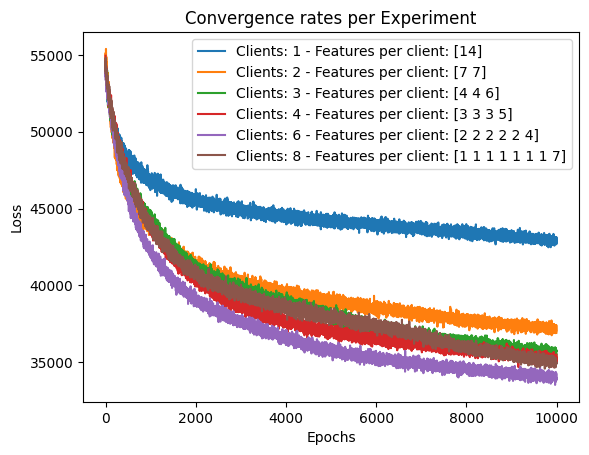

In [169]:
np.random.seed(42)
torch.manual_seed(42)

loss = []
features_per_client_list = []
num_clients = [1, 2, 3, 4, 6, 8]
for num_client in num_clients:
    print(f"----------------Clients: {num_client}----------------")
    X, y, client_feature_names, features_per_client = data_process(num_clients = num_client)
    features_per_client_list.append(features_per_client)
    Network = model_initial(client_feature_names)
    train_loss = train_test(X, y, Network, client_feature_names, num_clients = num_client, EPOCHS = 10000, BATCH_SIZE = 512)
    loss.append(train_loss)
loss_visualize_VAE(loss, num_clients, features_per_client_list)

Seems that 6 clients with [2, 2, 2, 2, 2, 4] converge most quickly.

### For any questions regarding this assignment, send an email to a.shankar@tudelft.nl